<a href="https://colab.research.google.com/github/heroza/Experiment-0/blob/main/ISIC%20Dataset%20using%20Inception-V3%20Transfer%20Learning%20with%20Fine%20Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download nodoubttome/skin-cancer9-classesisic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 99% 776M/786M [00:02<00:00, 230MB/s]
100% 786M/786M [00:03<00:00, 273MB/s]


In [2]:
! unzip /content/skin-cancer9-classesisic.zip

Archive:  /content/skin-cancer9-classesisic.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inflating: Ski

Load Data

In [2]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_data(path: str):
    dir = Path(path)
    # list of all filepathes
    filepaths = list(dir.glob(r'**/*.jpg'))
    # list of labels extracted from last foldername of filepath
    labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))
    # series of string filepathes
    filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
    # series of string labels
    labels = pd.Series(labels, name='Labels').astype(str)
    # merge series to dataframe df
    df = pd.merge(filepaths, labels, right_index=True, left_index=True)
    # Resampling complete rows and reset the index
    return df.sample(frac=1).reset_index(drop=True)


df = load_data('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [5]:
df.head(3)

,FilePaths,Labels
0,/content/Skin cancer ISIC The International Sk...,basal cell carcinoma
1,/content/Skin cancer ISIC The International Sk...,nevus
2,/content/Skin cancer ISIC The International Sk...,melanoma


Label Distribution

[Text(0, 0, 'seborrheic keratosis'),
 Text(0, 0, 'dermatofibroma'),
 Text(0, 0, 'actinic keratosis'),
 Text(0, 0, 'vascular lesion'),
 Text(0, 0, 'squamous cell carcinoma'),
 Text(0, 0, 'nevus'),
 Text(0, 0, 'basal cell carcinoma'),
 Text(0, 0, 'melanoma'),
 Text(0, 0, 'pigmented benign keratosis')]

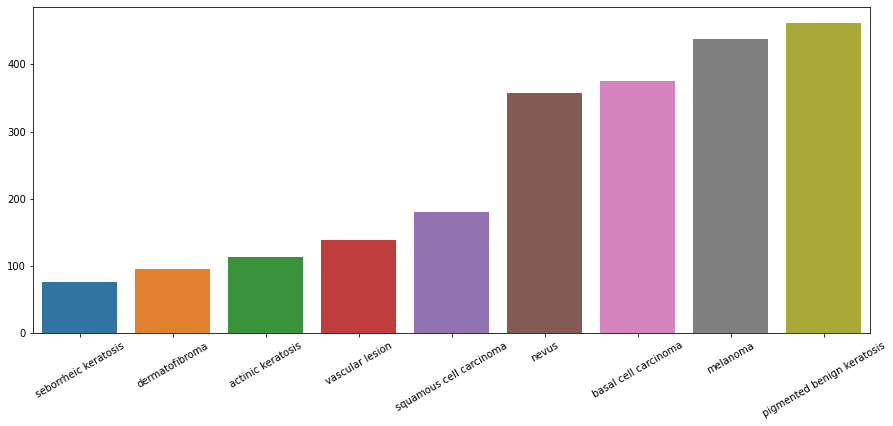

In [6]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

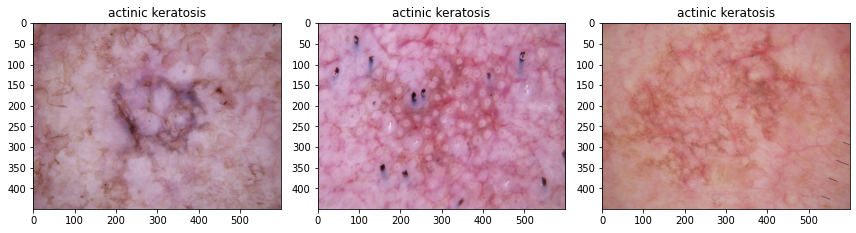

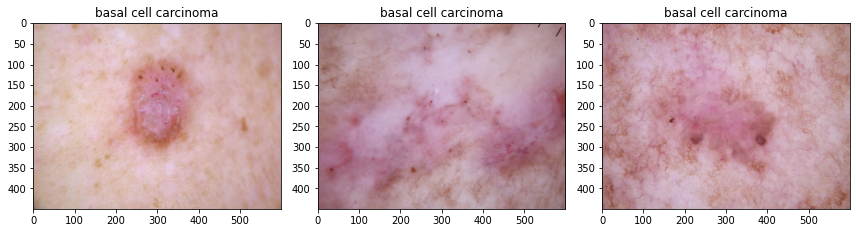

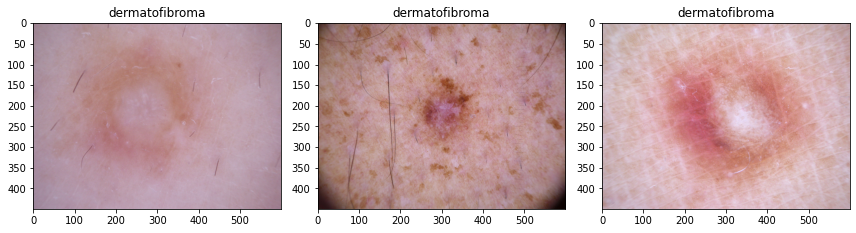

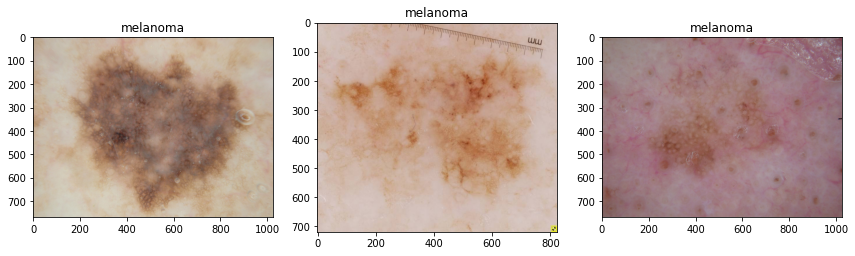

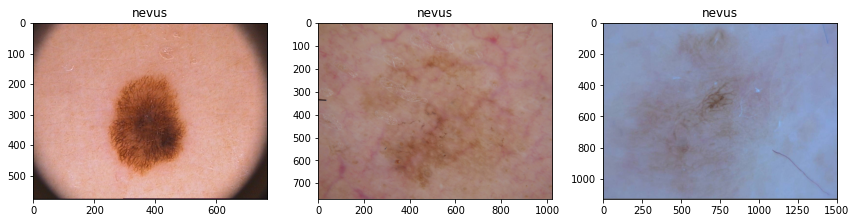

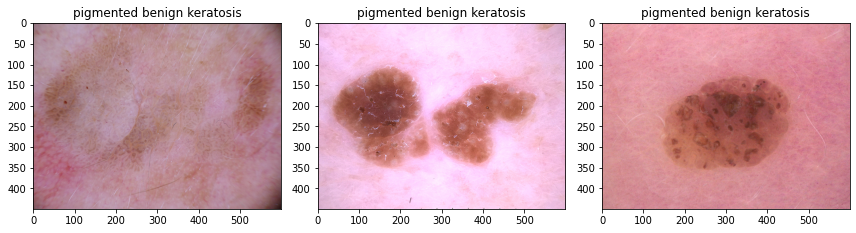

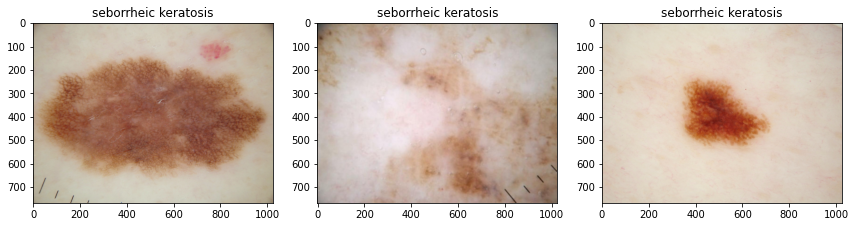

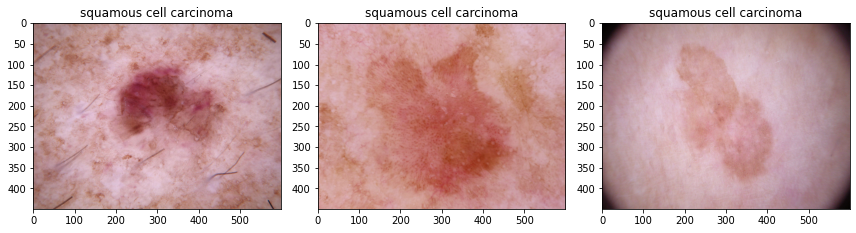

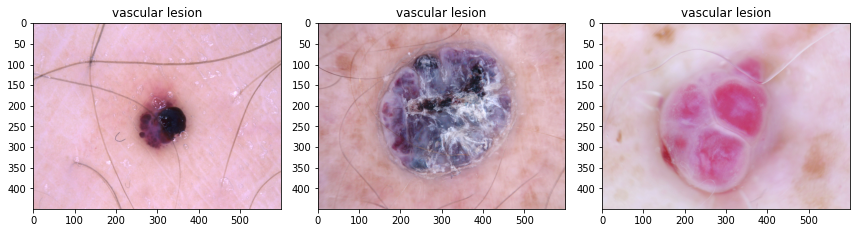

In [7]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Split dataset to train and val

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# stratified train and val (20%) datasets
X_train, X_val = train_test_split(df, test_size=0.2, stratify=df['Labels'], random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (1791, 2)
Val Data:  (448, 2)


Data Augmentation

In [6]:
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator

In [7]:
# number of samples/images per iteration
BATCH_SIZE = 32
# input image size
IMG_SIZE = (224,224) #use AlexNet inpu size instead (224, 224)

In [8]:
img_data_gen = ImageDataGenerator(shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

X_train = img_data_gen.flow_from_dataframe(dataframe=X_train,
                                           x_col='FilePaths',
                                           y_col='Labels',
                                           target_size=IMG_SIZE,
                                           color_mode='rgb',
                                           class_mode='categorical',
                                           batch_size=BATCH_SIZE,
                                           seed=1)

X_val = img_data_gen.flow_from_dataframe(dataframe=X_val,
                                         x_col='FilePaths',
                                         y_col='Labels',
                                         target_size=IMG_SIZE,
                                         color_mode='rgb',
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         seed=1)

Found 1791 validated image filenames belonging to 9 classes.
Found 448 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

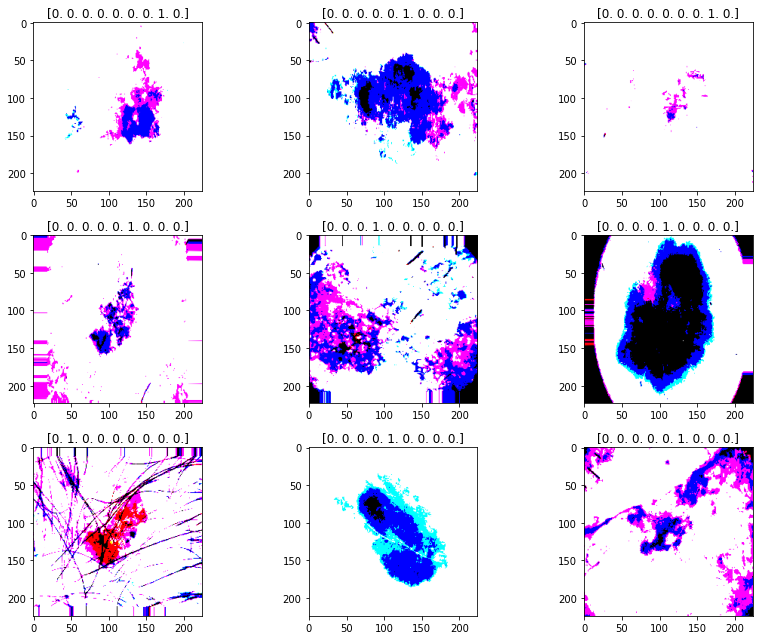

In [9]:
fit, ax = plt.subplots(nrows=3, ncols=3, figsize=(12,9))

for i, a in enumerate(ax.flat):
    img, label = X_train.next()
    a.imshow(img[0],)
    a.set_title(label[0])

plt.tight_layout()
plt.show()

Create and compile the model

# Inception-V3 Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [11]:
# count of epchos
EPOCHS = 15

In [25]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

# train the model on the new data for a few epochs
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 58s 984ms/step - loss: 11.2794 - accuracy: 0.2451 - val_loss: 2.6963 - val_accuracy: 0.2835
Epoch 2/15
56/56 [==============================] - 53s 950ms/step - loss: 2.4242 - accuracy: 0.3004 - val_loss: 2.7824 - val_accuracy: 0.2634
Epoch 3/15
56/56 [==============================] - 52s 938ms/step - loss: 2.0719 - accuracy: 0.3322 - val_loss: 1.9860 - val_accuracy: 0.3504
Epoch 4/15
56/56 [==============================] - 52s 934ms/step - loss: 1.9686 - accuracy: 0.3495 - val_loss: 2.0661 - val_accuracy: 0.3281
Epoch 5/15
56/56 [==============================] - 52s 928ms/step - loss: 1.8112 - accuracy: 0.3685 - val_loss: 1.8383 - val_accuracy: 0.3170
Epoch 6/15
56/56 [==============================] - 52s 929ms/step - loss: 1.7094 - accuracy: 0.4031 - val_loss: 1.8001 - val_accuracy: 0.3638
Epoch 7/15
56/56 [==============================] - 52s 935ms/step - loss: 1.6954 - accuracy: 0.4037 - val_loss: 1.7696 - val_accuracy: 0.343

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_4
1 conv2d_282
2 batch_normalization_282
3 activation_282
4 conv2d_283
5 batch_normalization_283
6 activation_283
7 conv2d_284
8 batch_normalization_284
9 activation_284
10 max_pooling2d_12
11 conv2d_285
12 batch_normalization_285
13 activation_285
14 conv2d_286
15 batch_normalization_286
16 activation_286
17 max_pooling2d_13
18 conv2d_290
19 batch_normalization_290
20 activation_290
21 conv2d_288
22 conv2d_291
23 batch_normalization_288
24 batch_normalization_291
25 activation_288
26 activation_291
27 average_pooling2d_27
28 conv2d_287
29 conv2d_289
30 conv2d_292
31 conv2d_293
32 batch_normalization_287
33 batch_normalization_289
34 batch_normalization_292
35 batch_normalization_293
36 activation_287
37 activation_289
38 activation_292
39 activation_293
40 mixed0
41 conv2d_297
42 batch_normalization_297
43 activation_297
44 conv2d_295
45 conv2d_298
46 batch_normalization_295
47 batch_normalization_298
48 activation_295
49 activation_298
50 average_pooling2d_28
51 conv2d_294
52

In [26]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 249
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst = model.fit(X_train, validation_data=X_val, epochs=EPOCHS)

Epoch 1/15
56/56 [==============================] - 59s 975ms/step - loss: 2.0554 - accuracy: 0.2094 - val_loss: 2.0302 - val_accuracy: 0.2545
Epoch 2/15
56/56 [==============================] - 53s 941ms/step - loss: 2.0202 - accuracy: 0.2261 - val_loss: 2.0251 - val_accuracy: 0.2433
Epoch 3/15
56/56 [==============================] - 57s 1s/step - loss: 1.9972 - accuracy: 0.2451 - val_loss: 1.9988 - val_accuracy: 0.2612
Epoch 4/15
56/56 [==============================] - 52s 932ms/step - loss: 1.9791 - accuracy: 0.2630 - val_loss: 1.9824 - val_accuracy: 0.2634
Epoch 5/15
56/56 [==============================] - 53s 947ms/step - loss: 1.9630 - accuracy: 0.2674 - val_loss: 1.9682 - val_accuracy: 0.2478
Epoch 6/15
56/56 [==============================] - 52s 939ms/step - loss: 1.9522 - accuracy: 0.2831 - val_loss: 1.9552 - val_accuracy: 0.2634
Epoch 7/15
56/56 [==============================] - 53s 940ms/step - loss: 1.9422 - accuracy: 0.2803 - val_loss: 1.9489 - val_accuracy: 0.2656
Ep

Load test data

In [22]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [23]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis


In [24]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


seborrheic keratosis           3
vascular lesion                3
actinic keratosis             16
pigmented benign keratosis    16
squamous cell carcinoma       16
basal cell carcinoma          16
dermatofibroma                16
nevus                         16
melanoma                      16
Name: Labels, dtype: int64

Preprocess test image

In [27]:
# image preprocessing
X_test = img_data_gen.flow_from_dataframe(dataframe=X_test,
                                          x_col='FilePaths',
                                          y_col='Labels',
                                          target_size=IMG_SIZE,
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, # necessary fpr confusion matrix
                                          seed=1)

Found 118 validated image filenames belonging to 9 classes.


Evaluate model againts test data

In [28]:
res = model.evaluate(X_test)

4/4 [==============================] - 8s 2s/step - loss: 2.2145 - accuracy: 0.2712


The accuracy

In [29]:
# accuracy
print(f'Train Accuracy: {hst.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 34.00
Val Accuracy: 33.04
Test Accuracy: 27.12
Train Loss: 187.74
Val Loss: 188.06
Test Loss: 221.45


Calculate y_pred

In [ ]:
# predicted labels
Y_pred = model.predict(X_test)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Calculate y_true

In [ ]:
# true labels
y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
class_labels = list(X_test.class_indices.keys())
print("labels", len(class_labels))

The confusion metric

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.ticker import FuncFormatter
import textwrap as tw

In [ ]:
# compare with true labels
cfm = confusion_matrix(y_pred, y_true, normalize='true')

# plot size
fig, ax = plt.subplots(figsize=(18,18))
# print confusion matrix
s = sns.heatmap(cfm,
               annot=True,
               cmap=['#ff0000', '#09AA00'],
               center=0.8,
               fmt='.1%',
               linewidths=.5,
               cbar_kws={'format': FuncFormatter(lambda x, pos: '{:.0%}'.format(x))}, #'label': 'Percentage' 
               linecolor='white',
               ax=ax)
# set labels
s.set(xlabel='Predict', ylabel='True')
s.set(title='Confusion Matrix')
s.set_yticklabels([tw.fill(e, 10) for e in class_labels])
s.set_xticklabels([tw.fill(e, 10) for e in class_labels])